In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scipy
sc.settings.verbosity = 3
sc.logging.print_header()
sc.set_figure_params(dpi=100, dpi_save=100)
    
import scvelo as scv
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.logging.print_versions()

import cellrank as cr
cr.settings.verbosity = 3
cr.logging.print_versions()

import matplotlib.pyplot as pl
from matplotlib import rcParams

/home/yqcj/miniconda3/envs/scrublet/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yqcj/miniconda3/envs/scrublet/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yqcj/miniconda3/envs/scrublet/lib/python3.9/site-packages/umap/d

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.21.6 scipy==1.11.1 pandas==1.3.5 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 louvain==0.8.0 pynndescent==0.5.10
scvelo==0.2.5  scanpy==1.9.3  anndata==0.9.1  loompy==3.0.7  numpy==1.21.6  scipy==1.11.1  matplotlib==3.7.2  sklearn==1.3.0  pandas==1.3.5  


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


cellrank==1.5.1 scanpy==1.9.3 anndata==0.9.1 numpy==1.21.6 numba==0.57.1 scipy==1.11.1 pandas==1.3.5 pygpcca==1.0.4 scikit-learn==1.3.0 statsmodels==0.14.0 python-igraph==0.10.6 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.7.2 seaborn==0.12.2


In [9]:
raw=sc.read('/mnt/g/YS_work2/5.Fib_Epi/YS_adata_fib_epi_raw.h5ad')
raw

AnnData object with n_obs × n_vars = 29545 × 36601
    obs: 'predicted_doublets', 'batch'
    var: 'gene_ids'

In [2]:
processed = sc.read('/mnt/g/YS_work2/5.Fib_Epi/YS_adata_fib_epi_after_newcelltype.h5ad')
processed

AnnData object with n_obs × n_vars = 29545 × 5000
    obs: 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'leiden', 'Fib_Epi_Cluster'
    var: 'gene_ids', 'mt', 'rp', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Fib_Epi_Cluster_colors', 'batch_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
adata.obsm['X_umap']=processed.obsm['X_umap']
adata.obs['leiden']= processed.obs['leiden']
adata.uns['leiden_colors']=processed.uns['leiden_colors']
adata.obs['Fib_Epi_Cluster']=processed.obs['Fib_Epi_Cluster']
adata.uns['Fib_Epi_Cluster_colors']=processed.uns['Fib_Epi_Cluster_colors']

In [5]:
ldata=sc.read('/mnt/g/YS-Work/3.Scvelo/YS_raw_ldata.h5ad', cache=True)
ldata

AnnData object with n_obs × n_vars = 193180 × 36601
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [6]:
import pandas as pd

# 修改 ldata 的 CellID 以匹配 adata 的格式
def reformat_cell_id(cell_id):
    new_id = cell_id.split(':')[1].replace('x', '-1')
    return new_id

new_index = ldata.obs.index.map(reformat_cell_id)
ldata.obs.index = pd.Index(new_index, name='CellID')
ldata.obs

,batch
CellID,
AAAGATGAGGAGTTTA-1-S-1,S-1
AAAGATGCACTGTCGG-1-S-1,S-1
AAAGATGTCACTATTC-1-S-1,S-1
AAAGCAAAGTGGGTTG-1-S-1,S-1
AAACGGGTCCTGCTTG-1-S-1,S-1
...,...
TTTGTCACAAATACAG-1-SMC25T,SMC25T
TTTGTCAAGCGCTCCA-1-SMC25T,SMC25T
TTTGCGCCATGTTCCC-1-SMC25T,SMC25T


In [7]:
adata = scv.utils.merge(adata, ldata)
adata

AnnData object with n_obs × n_vars = 29545 × 36591
    obs: 'predicted_doublets', 'batch', 'leiden', 'Fib_Epi_Cluster', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_ids', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'Fib_Epi_Cluster_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [8]:
adata.write('/mnt/g/YS_work2/7.Fib_Epi_trace/YS_raw_ldata_adata_fib_epi.h5ad')

In [12]:
adata=sc.read('/mnt/g/YS_work2/7.Fib_Epi_trace/YS_raw_ldata_adata_fib_epi.h5ad')
adata

AnnData object with n_obs × n_vars = 29545 × 36591
    obs: 'predicted_doublets', 'batch', 'leiden', 'Fib_Epi_Cluster', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_ids', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'Fib_Epi_Cluster_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

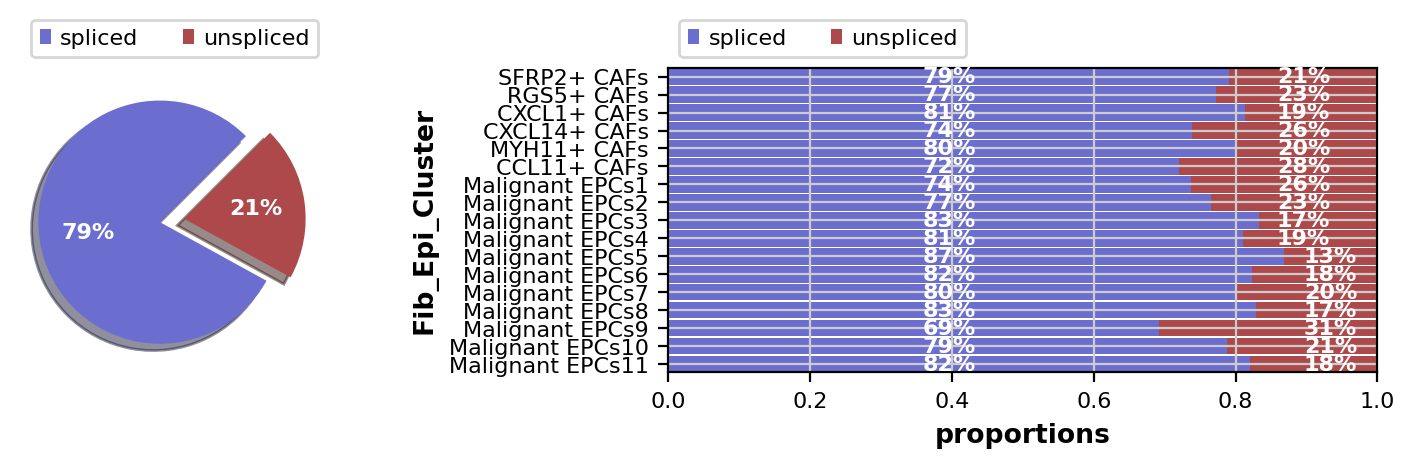

In [13]:
# display the proportions of spliced/unspliced counts
scv.pl.proportions(adata, groupby='Fib_Epi_Cluster')

In [14]:
scv.pp.filter_and_normalize(adata, min_shared_counts=15, n_top_genes=5000, enforce=True)
scv.pp.log1p(adata)
adata

Filtered out 23285 genes that are detected 15 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 5000 highly variable genes.


AnnData object with n_obs × n_vars = 29545 × 5000
    obs: 'predicted_doublets', 'batch', 'leiden', 'Fib_Epi_Cluster', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_ids', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'Fib_Epi_Cluster_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [15]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=10)
adata

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:13)
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


AnnData object with n_obs × n_vars = 29545 × 5000
    obs: 'predicted_doublets', 'batch', 'leiden', 'Fib_Epi_Cluster', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_ids', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'Fib_Epi_Cluster_colors', 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [16]:
scv.tl.recover_dynamics(adata, n_jobs=16)
scv.tl.velocity(adata, mode='dynamical', use_raw=False)
scv.tl.velocity_graph(adata, n_jobs=16)


recovering dynamics (using 16/36 cores)


  0%|          | 0/1120 [00:00<?, ?gene/s]

/home/yqcj/miniconda3/envs/scrublet/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/yqcj/miniconda3/envs/scrublet/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:03:27) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:36) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 16/36 cores)


  0%|          | 0/29545 [00:00<?, ?cells/s]

/home/yqcj/miniconda3/envs/scrublet/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [17]:
adata.obs['leiden']=processed.obs['leiden']
adata.uns['leiden_colors']=processed.uns['leiden_colors']
adata.obs['Fib_Epi_Cluster']=processed.obs['Fib_Epi_Cluster']
adata.uns['Fib_Epi_Cluster_colors']=processed.uns['Fib_Epi_Cluster_colors']
metastases_status = {
    'S-1': 'Without Metastases',
    'S-2': 'Without Metastases',
    'S-3': 'With Metastases',
    'S-5': 'With Metastases',
    'S-6': 'Without Metastases',
    'S-7': 'With Metastases',
    'S-8': 'Without Metastases',
    'S-9': 'With Metastases',
    'S-10': 'With Metastases',
    'S-11': 'Without Metastases',
    'S-12': 'Without Metastases',
    'S-13': 'With Metastases',
    'S-14': 'Without Metastases',
    'COL07': 'With Metastases',
    'COL12': 'With Metastases',
    'COL16': 'With Metastases',
    'SMC18T': 'Without Metastases',
    'SMC19T': 'Without Metastases',
    'SMC21T': 'With Metastases',
    'SMC22T': 'Without Metastases',
    'SMC23T': 'Without Metastases',
    'SMC25T': 'With Metastases',
}
adata.obs['Metastases'] = adata.obs['batch'].map(metastases_status)

In [18]:
adata

AnnData object with n_obs × n_vars = 29545 × 5000
    obs: 'predicted_doublets', 'batch', 'leiden', 'Fib_Epi_Cluster', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'Metastases'
    var: 'gene_ids', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'Fib_Epi_Cluster_colors', 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'leiden_colors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs', 'loss'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connec

In [21]:
adata.write('/mnt/g/YS_work2/7.Fib_Epi_trace/YS_adata_fib_epi_before_velocity_5000_nc15_nb10_np30.h5ad')

In [3]:
adata=sc.read('/mnt/g/YS_work2/7.Fib_Epi_trace/YS_adata_fib_epi_before_velocity_5000_nc15_nb10_np30.h5ad')
adata

AnnData object with n_obs × n_vars = 29545 × 5000
    obs: 'predicted_doublets', 'batch', 'leiden', 'Fib_Epi_Cluster', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'Metastases'
    var: 'gene_ids', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'Fib_Epi_Cluster_colors', 'leiden_colors', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'co

Consider running `set_figure_params(dpi_save=...)`, which will adjust `matplotlib.rcParams['savefig.dpi']`
saving figure to file ./figures/scvelo_fib_epi_all_5000_nc15_nb10_np30.svg


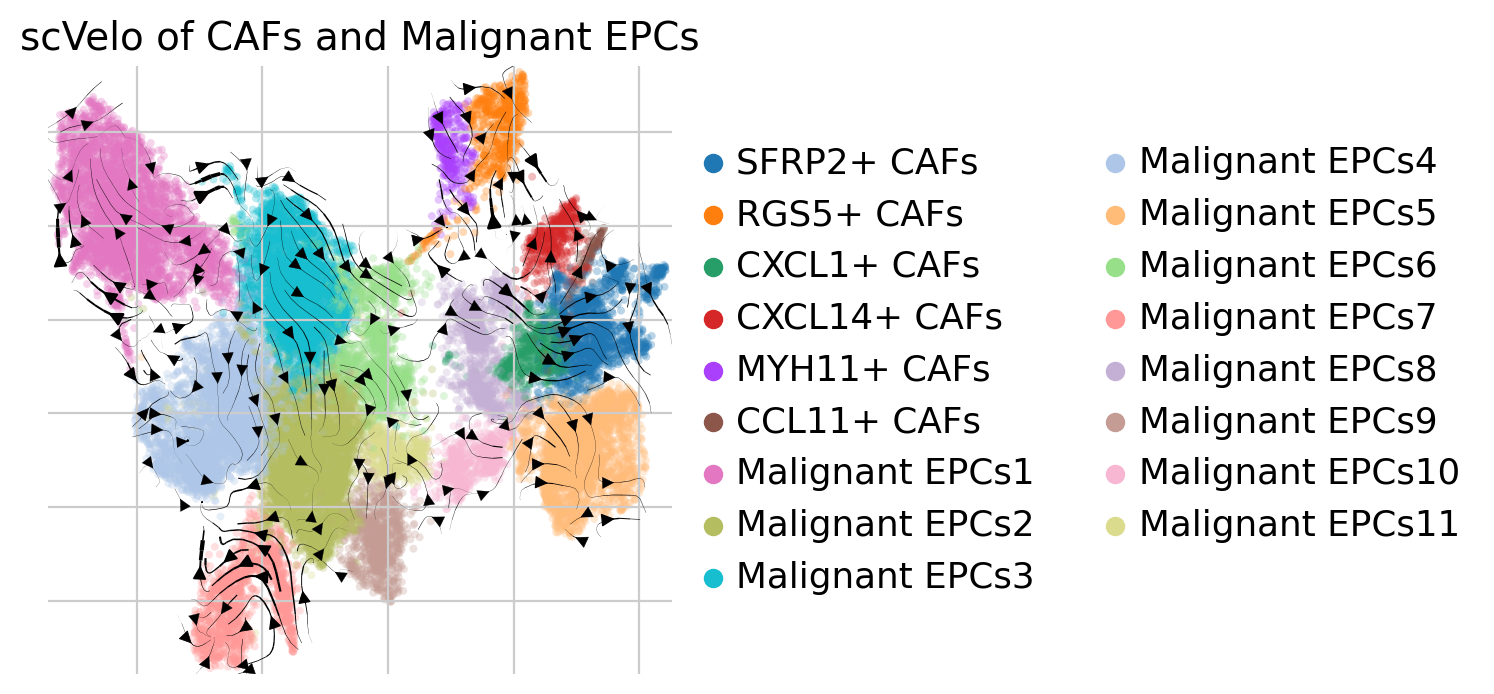

In [4]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['Fib_Epi_Cluster'], legend_loc='right margin', title='scVelo of CAFs and Malignant EPCs', use_raw=False, frameon=False, save='fib_epi_all_5000_nc15_nb10_np30.svg')

In [19]:
adata.write('/mnt/g/YS_work2/7.Fib_Epi_trace/YS_raw_ldata_adata_fib_epi_sub.h5ad')

In [ ]:
scv.tl.rank_velocity_genes(adata, groupby='Fib_Epi_Cluster', min_corr=0.4)
df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.to_csv('Ys_fib_epi_velocity_genes.csv', index=False)